In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (8, 5) },
    style='ticks',
    color_codes=True,
    font_scale=1
)
%config InlineBackend.figure_format = 'retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders -q
!pip install xgboost

# ML utilities
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics

# Models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Encoding and metrics
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [23]:
df = pd.read_csv("../data/Dataset_ecommerce.csv")

In [24]:
df.head(2)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali


In [25]:
df.shape

(541909, 8)

In [26]:
#check for more info on df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [27]:
#Descriptive stat
df.describe(include ="all")

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
count,541909,541909,406829.000000,541909,541909,541909.000000,541909.000000,541909
unique,25900,23260,NaN,9000,10,NaN,NaN,28
top,573585,2011-10-31 14:41:00,NaN,SC2014,Sports Equipment,NaN,NaN,Cote d'Ivoire
freq,1114,1114,NaN,96,54765,NaN,NaN,19651
mean,NaN,NaN,15287.690570,NaN,NaN,50.534748,50.476354,NaN
std,NaN,NaN,1713.600303,NaN,NaN,28.849367,28.564775,NaN
min,NaN,NaN,12346.000000,NaN,NaN,1.000000,1.000000,NaN
25%,NaN,NaN,13953.000000,NaN,NaN,26.000000,25.750000,NaN
50%,NaN,NaN,15152.000000,NaN,NaN,51.000000,50.430000,NaN
75%,NaN,NaN,16791.000000,NaN,NaN,76.000000,75.180000,NaN


In [28]:
df.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [29]:
df.dropna(inplace = True)

In [30]:
#convert to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head(5)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [31]:
# Create Total Price Column 
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

In [32]:
# Checking Unique values in the columns
print("Unique_Customers:", df['CustomerID'].nunique())
print("Unique_Products:", df['StockCode'].nunique())
print("Countries:", df['Country'].nunique())

Unique_Customers: 4372
Unique_Products: 9000
Countries: 28




# Exploratory Data Analysis


### sales trend visualization

In [35]:
# sales trend over time 
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()

In [36]:
monthly_sales

InvoiceDate
2010-12    6.792367e+07
2011-01    5.582933e+07
2011-02    5.208536e+07
2011-03    7.137210e+07
2011-04    5.914003e+07
2011-05    7.434151e+07
2011-06    7.109639e+07
2011-07    7.040789e+07
2011-08    6.994326e+07
2011-09    1.036281e+08
2011-10    1.287425e+08
2011-11    1.677331e+08
2011-12    4.519251e+07
Freq: M, Name: TotalPrice, dtype: float64

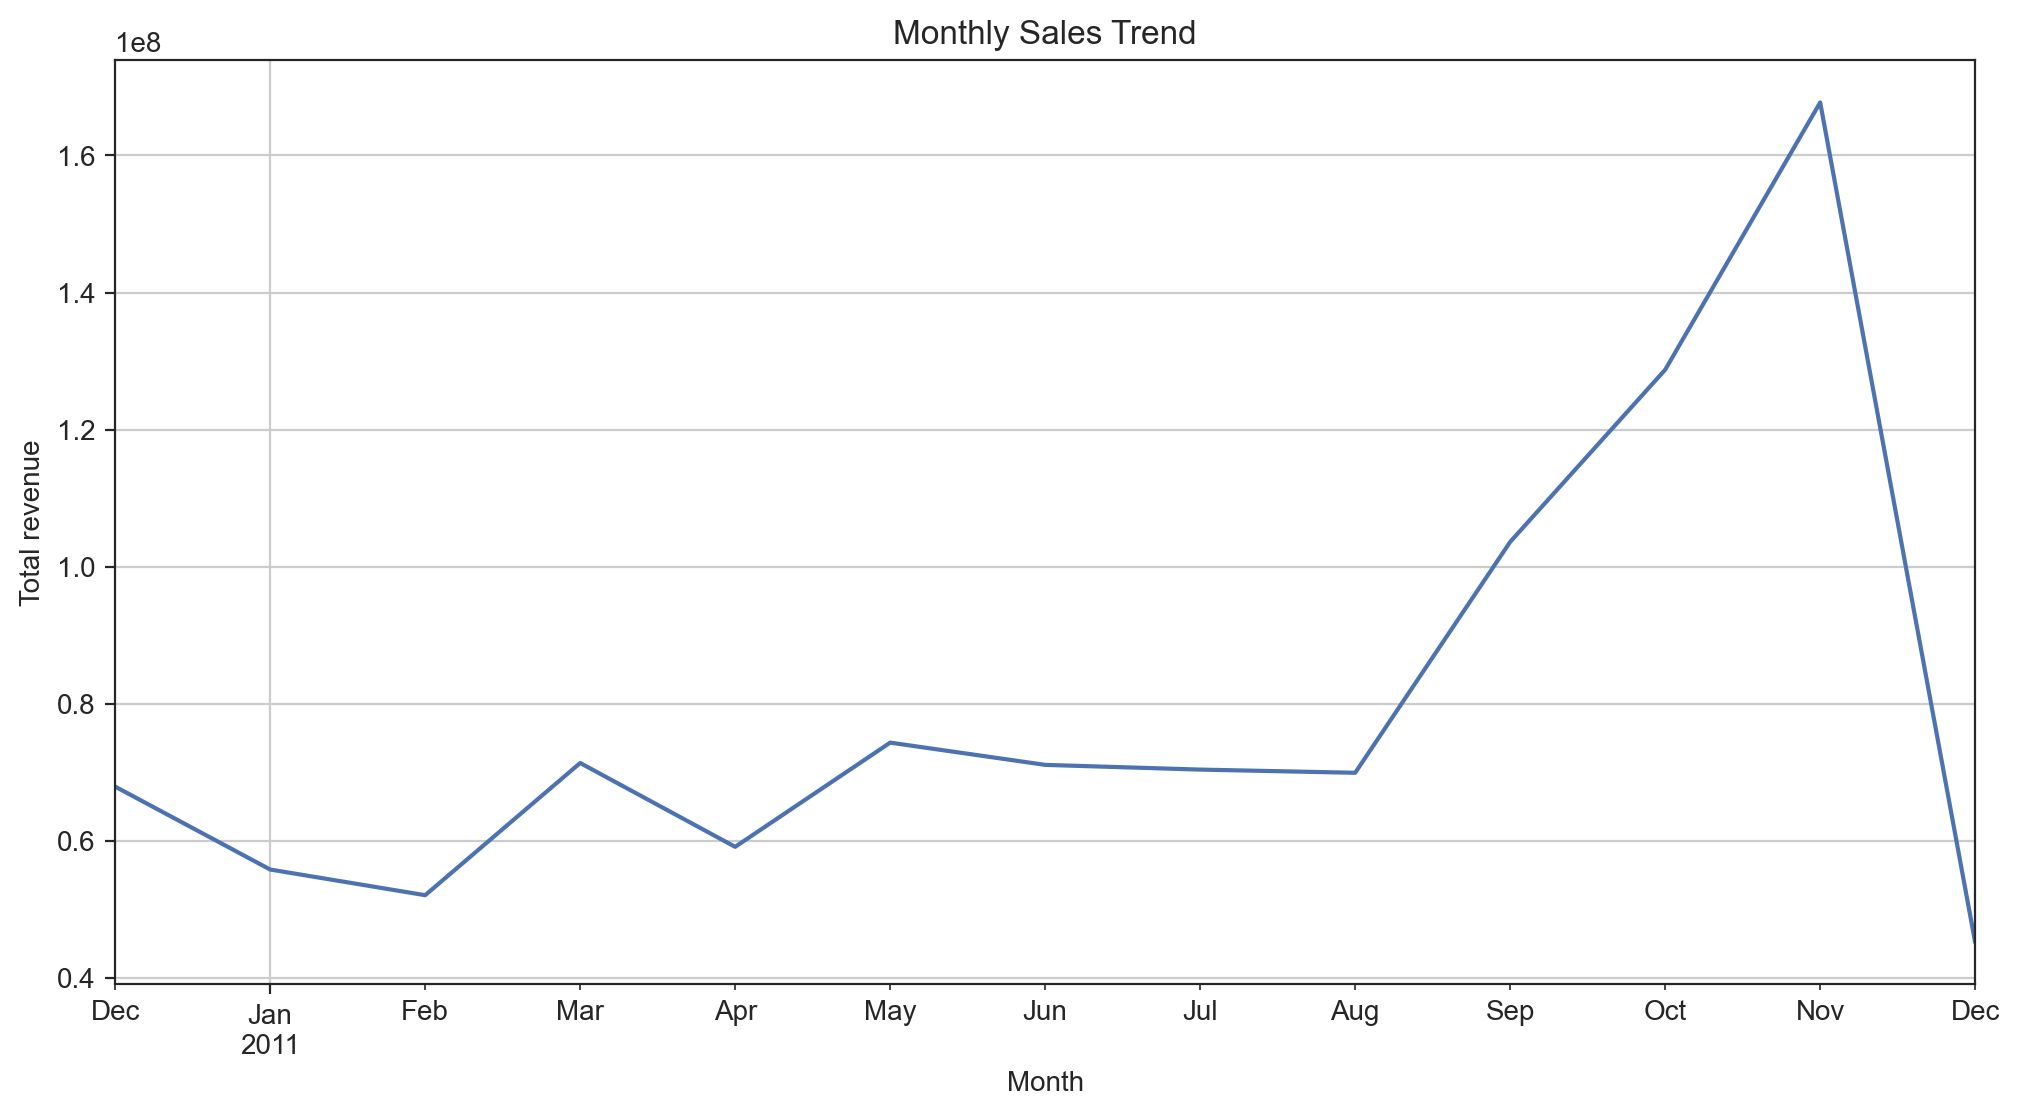

In [37]:
# create folder one level up
import os
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)
# Create a line chart and save 

plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.xlabel('Month')
plt.ylabel('Total revenue')
plt.title('Monthly Sales Trend')
plt.grid(True)

#save as png
output_path = os.path.join(output_dir, 'monthly_sales_trend.png')

# Display the plot
plt.show()

Sales Trend Obsrvations

* Initial Dip: sales declined from December through february hiting a low in february.
* Moderate recovery: There was a slight growth in sales from March and May followed by a flat trend from June to August.
* Strong Growth: There was a sharp increase in revenue from September to November,with November being the peak month.
* Sharp drop : There was a significant decline in revenue after the peak period, which is likely a result of seasonal closure or end of data collection.

## Top Selling Products

In [61]:
#Top selling products 
#Total quantity sold per product
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)


In [63]:
top_products

Description
Shoes               2069190
Jewelry             2065153
Toys                2063396
Furniture           2063221
Sports Equipment    2060571
Cloths              2054709
Cosmetics           2051088
Kitchenware         2046704
Electronics         2036733
Books               2025341
Name: Quantity, dtype: int64

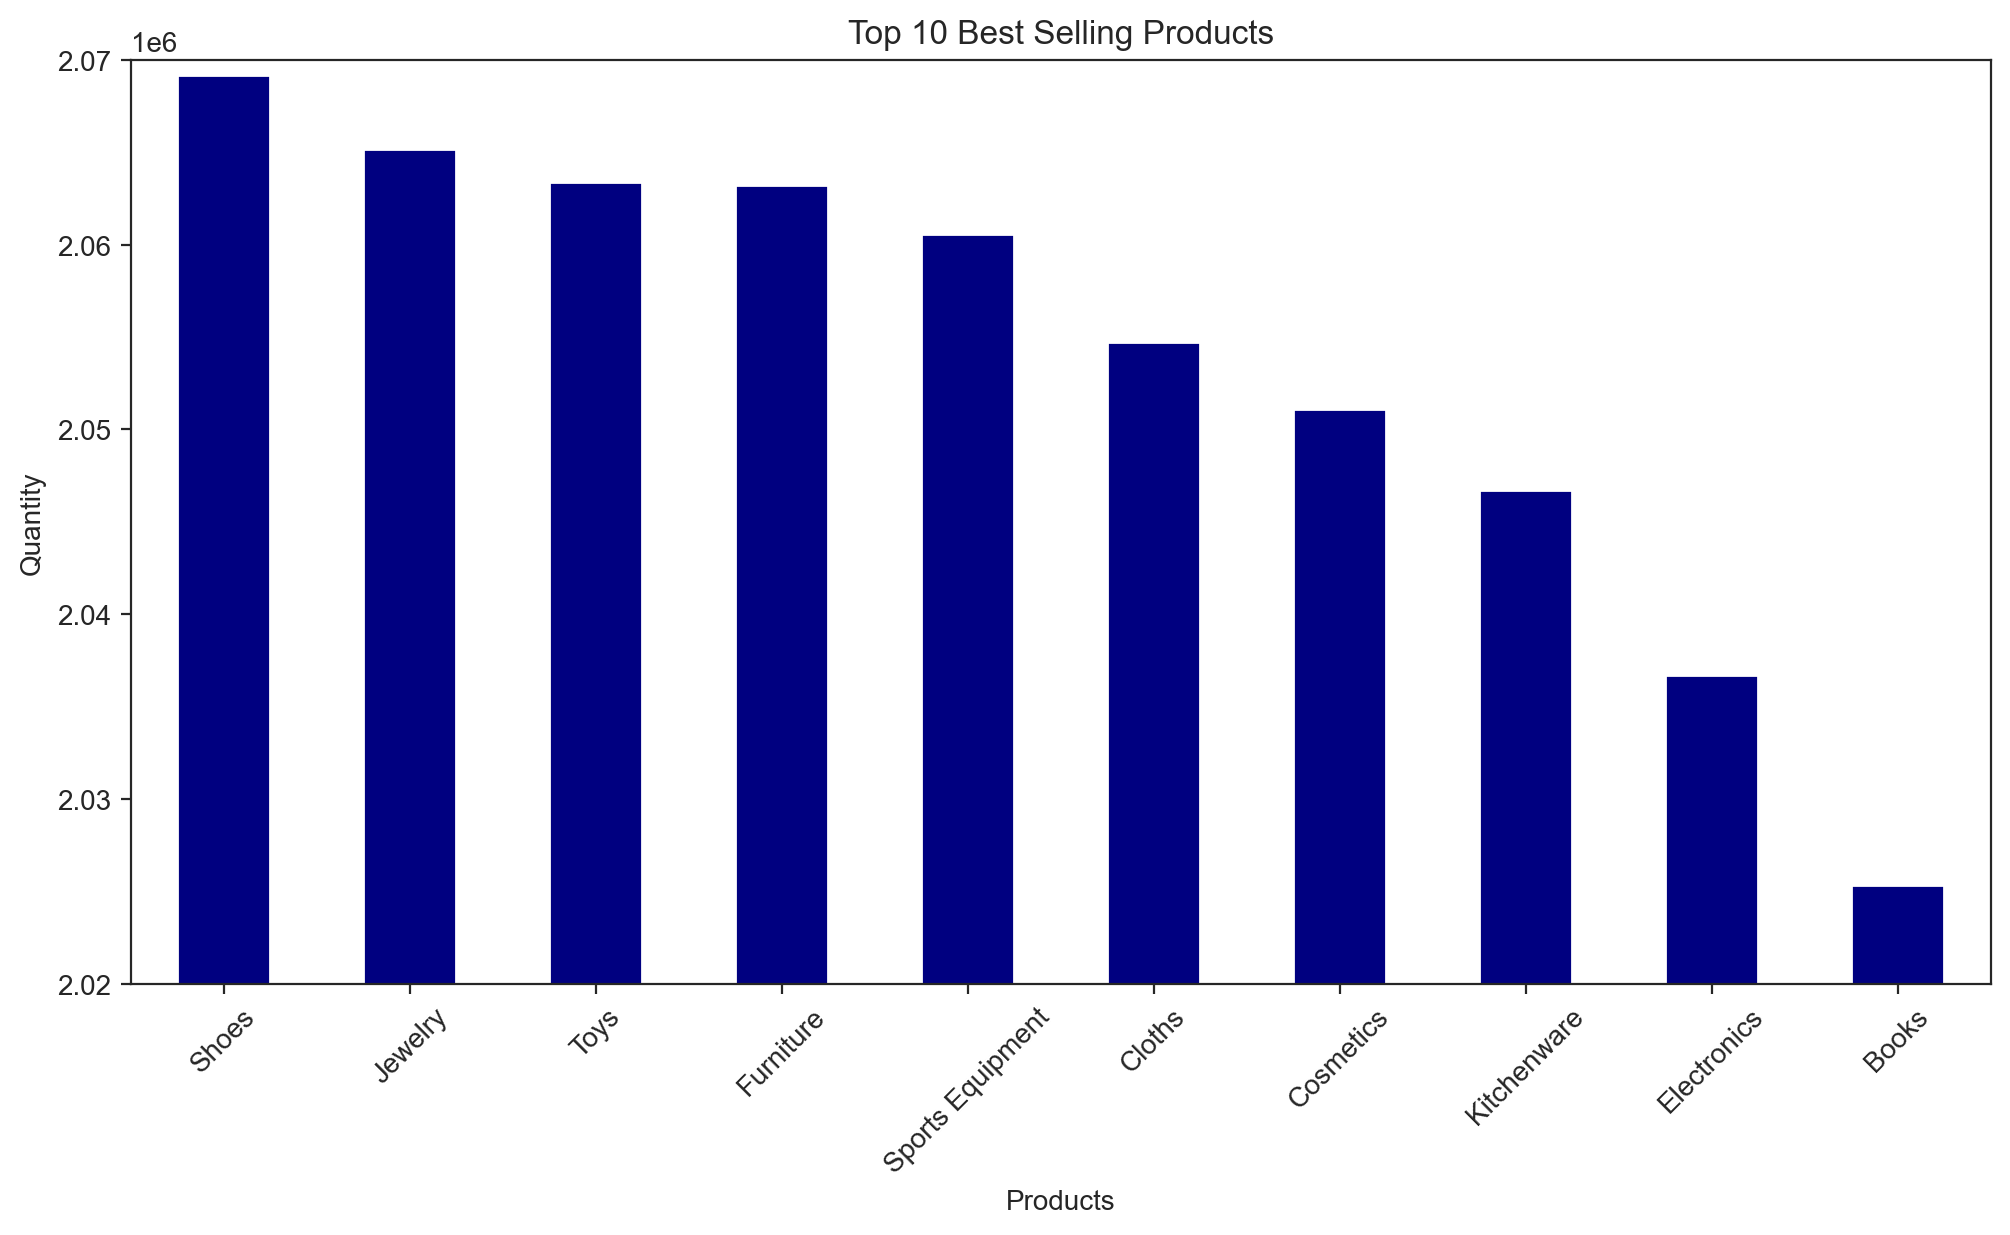

In [65]:
# create folder one level up

output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualizations')
os.makedirs(output_dir,exist_ok=True)

#plot
plt.figure(figsize=(12, 6))
top_products.plot(kind= "bar", color='navy')
plt.xlabel('Products')
plt.ylabel('Quantity')
plt.title('Top 10 Best Selling Products')
plt.xticks(rotation =45 )
plt.ylim(2.02e6, 2.07e6)

#save as png
output_path = os.path.join(output_dir, 'Top_10_Best_Selling_Products.png')

# Display the plot
plt.show()

### Top 10 Best-Selling Products- key Insights
* **Narrow Sales Range**: All top 10 products have sales quantities indicating a very tight clustering of performance
* **Leading Product** : Shoes appears to be the best-selling item, with sales slightly exceeding 2.06 million units.
* **Minimal Variation**: There's remarkably little difference in sales performance among these top products, suggesting they might be complementary items or variations of similar products.
* **Consistent Performance**: The top 10 products show a gradual decline in sales rather than any dramatic drops, indicating consistent consumer demand across these items.


## Customer Activities 

In [75]:
df['CustomerID'].nunique(),df['InvoiceNo'].nunique()

(4372, 22190)

In [ ]:
df.groupby('CustomerID')['InvoiceNo'].nunique().max()